In [2]:
# Evaluation mean f1-score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/train_data.npy')
# classes 0 - 3
y = np.genfromtxt('data/train_labels.csv', delimiter=' ', dtype=np.float32)

unique, counts = np.unique(y, return_counts=True)
print(counts) # features: 18286

[4040 1965  227  590]


In [162]:
from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=384, n_jobs=-1)

ind_train = np.concatenate((np.where(y == 0)[0][0:2000], np.where(y == 1)[0][:1500], np.where(y == 2)[0][:180], np.where(y == 3)[0][:450]))
ind_test = list(set(range(0, len(X))) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

#X_train, y_train = sm.fit_sample(X_train, y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(counts) # features: 18286

def sampleIt(X, y):
    X_new = []; y_new = []; sample_w = []
    for i, row_y in enumerate(y):
        for cl, p_i in enumerate(row_y):
            X_new.append(X[i])
            y_new.append(cl)
            sample_w.append(p_i)
    return X_new, y_new, sample_w

# X_train, y_train, w_train = sampleIt(X_train, y_train)
# X_test, y_test, w_test = sampleIt(X_test, y_test)

[2000 1500  180  450]


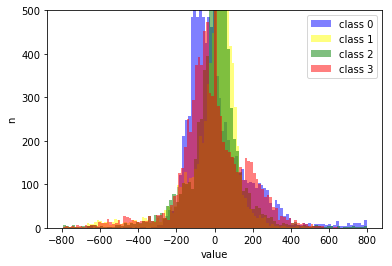

In [88]:
min_v = -800; max_v = 800;
plt.hist(X[0][(X[0] > min_v) & (X[0] < max_v) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[3][(X[3] > min_v) & (X[3] < max_v) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[45][(X[45] > min_v) & (X[45] < max_v) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[500][(X[500] > min_v) & (X[500] < max_v) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.ylim([0, 500])
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()

In [168]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=100, hist_bins=None):
        self.splits = splits
        self.hist_bins = hist_bins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [np.array([ -999.19763985,  -485.15192982,  -346.25374208,  -309.21737229,
        -142.67562916,    12.15726408,    69.22791529,   252.79300342,
         352.64728962,   714.95429379,  1010.25799923]), np.array([-1037.58845752,  -576.10344329,  -498.79902835,  -290.62505929,
        -122.17938841,   -46.0604679 ,   111.56523858,   139.86176822,
         306.94959424,   558.59907038,   911.98393353]), np.array([-1059.49206867,  -549.90628425,  -376.57310505,  -357.55737517,
        -143.37772956,   -93.95276057,   108.14882813,   248.30593439,
         313.9898497 ,   668.89202494,  1006.78420662])]
            
        for row in X:
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])
                #features.append(np.histogram(split, bins=self.hist_bins)[0])

            X_new.append(np.array(features).flatten())

        #print("features: "+str(len(X_new[0])))
        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=80)),
    ('scaler', StandardScaler()),
#    ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=-1))
    ('logreg', GradientBoostingClassifier(n_estimators=30))
#      ('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [167]:
from sklearn.metrics import f1_score, log_loss

# pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train}); print('fitted')
pipe.fit(X_train, y_train); print('fitted')
y_pred = pipe.predict(X_test);
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(unique); print(counts)

# Pass score: 0.62837
# Splits 80: 0.5739644970414202 (first class 2000 rows)
# GradientBoostingClassifier, 100, 0.6505588428665352
# 30, 0.6794871794871795 / 0.7176820208023774 [2200  463   26    3]
# Smote 4x2000: 0.5197409006785935
# Smote 4x3000: 0.5159574468085106 [1006  314  185  187]

fitted
f1 score: 0.7102526002971769
[ 0.  1.  2.  3.]
[2169  483   31    9]


In [146]:
import random
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=80, hist_bins=a)),
        ('scaler', StandardScaler()),
 #       ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=2))
        ('logreg', GradientBoostingClassifier(n_estimators=30))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test);

    score = f1_score(y_test, y_pred, average='micro')
    print("\x1b[1;31m%s\x1b[0m \t%s" % (score, a))
    
#for i in [0.01, 0.1, 1, 10]:
#    run(i)
    
hist_bins = [[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402],[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = []
        for b2 in b1:
            bins_new2.append(random.uniform(b2 - 80, b2 + 80))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.677843523997 	[array([-1078.59990995,  -550.02131919,  -473.91927231,  -326.67234932,
         -94.98085107,   -55.62696848,   104.78881501,   235.58812778,
         343.56114704,   707.83249652,   937.51629726]), array([-1075.77411532,  -483.91882043,  -467.85687368,  -222.10146979,
        -117.370593  ,   -73.06711624,   150.46299112,   152.67701252,
         363.07134956,   693.6869505 ,   913.44138148]), array([-991.73895121, -497.43880362, -378.61187344, -291.37511266,
       -112.78772154,  -92.06113802,   44.7171689 ,  158.70105147,
        415.71168125,  643.18180413,  933.16617305])]
0.679487179487 	[array([ -999.19763985,  -485.15192982,  -346.25374208,  -309.21737229,
        -142.67562916,    12.15726408,    69.22791529,   252.79300342,
         352.64728962,   714.95429379,  1010.25799923]), array([-1037.58845752,  -576.10344329,  -498.79902835,  -290.62505929,
        -122.17938841,   -46.0604679 ,   111.56523858,   139.86176822,
         306.94959424,   558.59907038, 

KeyboardInterrupt: 

In [67]:
# Get clusters as a start for the bins
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, n_jobs=-1, random_state=99)#, init="k-means++")

ind = np.concatenate((np.where(y == 0)[0][0:3], np.where(y == 1)[0][:3], np.where(y == 2)[0][:3], np.where(y == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    sample = sample[(sample > -500) & (sample < 500)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

#edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
#edges.append(1700)
"""

"""
edges

Process ForkPoolWorker-131:
Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/pyt

KeyboardInterrupt: 